# Additional Readings
You can read the full description of project here:
https://medium.com/@Markeko/speech-emotion-recognition-with-convolutional-neural-network-ae5406a1c0f7

# Import libraries

In [1]:
#Import data packages
import os
import sys
import glob
import numpy as np
import pandas as pd

#Import audio packages
import librosa
import librosa.display
from scipy.io import wavfile
import scipy.io.wavfile
import sys

#Import plotting packages
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import seaborn as sns

#Import Keras & Tensorflow packages
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

C:\Users\diego\Anaconda3\envs\emotion_capstone\lib\site-packages\librosa\util\decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\diego\Anaconda3\envs\emotion_capstone\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implem

# Read Files

There are two databases that were used for this project:
- RAVDESS: The RAVDESS file contains a unique filename that consists in a 7-part numerical identifier.
- TESS: The TESS file contains a unique letter at beginning of file name to identify the emotion.

## Read RAVDESS Dataset

In [2]:
#Build list of files
rawdata_list = os.listdir('RawData/')

In [3]:
#Review list of files
print(rawdata_list)

['03-01-01-01-01-01-01.wav', '03-01-01-01-01-01-03.wav', '03-01-01-01-01-01-04.wav', '03-01-01-01-01-01-05.wav', '03-01-01-01-01-01-06.wav', '03-01-01-01-01-01-07.wav', '03-01-01-01-01-01-08.wav', '03-01-01-01-01-01-09.wav', '03-01-01-01-01-01-10.wav', '03-01-01-01-01-02-01.wav', '03-01-01-01-01-02-03.wav', '03-01-01-01-01-02-04.wav', '03-01-01-01-01-02-05.wav', '03-01-01-01-01-02-06.wav', '03-01-01-01-01-02-07.wav', '03-01-01-01-01-02-08.wav', '03-01-01-01-01-02-09.wav', '03-01-01-01-01-02-10.wav', '03-01-01-01-02-01-01.wav', '03-01-01-01-02-01-02.wav', '03-01-01-01-02-01-03.wav', '03-01-01-01-02-01-04.wav', '03-01-01-01-02-01-05.wav', '03-01-01-01-02-01-06.wav', '03-01-01-01-02-01-07.wav', '03-01-01-01-02-01-08.wav', '03-01-01-01-02-01-09.wav', '03-01-01-01-02-01-10.wav', '03-01-01-01-02-02-01.wav', '03-01-01-01-02-02-02.wav', '03-01-01-01-02-02-03.wav', '03-01-01-01-02-02-04.wav', '03-01-01-01-02-02-05.wav', '03-01-01-01-02-02-06.wav', '03-01-01-01-02-02-07.wav', '03-01-01-01-02-02-

## LIbrosa & MFCC configuration
In order to analyze and standardize how each audio file feature was built, the following configurations were determined:

In [4]:
#sample feature
#librosa.core.load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
res_type_s = 'kaiser_best'
duration_s = None
sample_rate_s = 22050
offset_s = 0.5

#Mfcc
#librosa.feature.mfcc(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)
mfcc_sample_rate = 22050
n_mfcc = 40
axis_mfcc = 1

### RAVDESS get emotion features

File naming convention

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 

Filename identifiers 

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 02-01-06-01-02-01-12.mp4 
- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement "dogs" (02)
- 1st Repetition (01)
- 12th Actor (12)
- Female, as the actor ID number is even.

In [5]:
#Build list with target variables for each file
feeling_list=[]

#Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fear, 07 = disgust, 08 = surprised) 

for emotion_path in rawdata_list:
    if emotion_path.split('-')[2] == '01':
        feeling_list.append("neutral")
    elif emotion_path.split('-')[2] == '02':
        feeling_list.append("calm")
    elif emotion_path.split('-')[2] == '03':
        feeling_list.append("happy")
    elif emotion_path.split('-')[2] == '04':
        feeling_list.append("sad")
    elif emotion_path.split('-')[2] == '05':
        feeling_list.append("angry")
    elif emotion_path.split('-')[2] == '06':
        feeling_list.append("fear")
    elif emotion_path.split('-')[2] == '07':
        feeling_list.append("disgust")
    elif emotion_path.split('-')[2] == '08':
        feeling_list.append("surprised")
    else:
        feeling_list.append("unknown")

In [6]:
#Check list
feeling_list

['neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'calm',
 'ca

In [7]:
#Turn list into dataframe
labels = pd.DataFrame(feeling_list)

In [8]:
#Check shape
labels.shape

(1170, 1)

In [9]:
#Change index name to "emotion"
labels = labels.rename({0: 'emotion'}, axis=1)

In [10]:
labels.shape

(1170, 1)

In [11]:
#Count the number of files per emotion
labels_total = pd.DataFrame(labels.groupby(['emotion']).size())
labels_total

,0
emotion,
angry,184
calm,184
disgust,80
fear,184
happy,184
neutral,90
sad,184
surprised,80


### RAVDESS get audio features with librosa library

In [12]:

rawdata_ravdess = pd.DataFrame(columns=['feature'])
bookmark=0

for y in rawdata_list:
    #Change to kaiser_best & 22050 kHz
    #sr > target sampling rate
    #offset=0.5
    X, sample_rate = librosa.load('RawData/'+y, 
                                  res_type = res_type_s,
                                  duration = duration_s,
                                  sr = sample_rate_s,
                                  offset = offset_s)
    sample_rate = np.array(sample_rate)
    
    #Get MFCCs from each file
    mfccs = librosa.feature.mfcc(   y=X, 
                                    sr = mfcc_sample_rate, 
                                    n_mfcc = n_mfcc)
    
    #Calculate mean of MFCCs
    mfccs_mean = np.mean(    mfccs, 
                             axis = axis_mfcc)
    feature = mfccs_mean
    
    #Add MFCCs feature results to list
    rawdata_ravdess.loc[bookmark] = [feature]
    bookmark=bookmark+1   

In [13]:
#Verity data results
rawdata_ravdess.shape

(1170, 1)

In [14]:
#Verify that there are no null values
rawdata_ravdess.isnull().values.any()

False

In [15]:
# See array sample of features
rawdata_ravdess

,feature
0,"[-363.3887290340994, 77.68306674809371, -11.19..."
1,"[-326.91351899556, 77.65209081609632, -14.5439..."
2,"[-359.4689911204949, 66.02038723837009, -23.72..."
3,"[-376.3948495148282, 90.08743891794771, -3.517..."
4,"[-364.30013143857167, 77.39369743958628, -35.6..."
...,...
1165,"[-387.8787240853882, 36.04284862391279, -23.39..."
1166,"[-444.31812032605995, 56.227220762642375, -19...."
1167,"[-449.0887812706918, 22.074922409049478, -20.7..."
1168,"[-438.6358679821132, 62.339500696565516, -23.9..."


In [16]:
#Turn array into dataframe
rawdata_ravdess_final = pd.DataFrame(rawdata_ravdess['feature'].values.tolist())

In [17]:
#Analyze new dataframe shape
rawdata_ravdess_final.shape

(1170, 40)

In [18]:
# Check data sample
rawdata_ravdess_final.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-363.388729,77.683067,-11.194510,25.560407,-0.295472,8.327729,-9.751422,0.370547,-15.182420,-2.709384,...,-0.769595,-4.234061,-1.380629,-3.896914,-2.250014,-3.142226,-0.189935,-2.949018,-3.580094,-2.151387
1,-326.913519,77.652091,-14.543926,22.188295,-3.558177,3.815711,-18.927323,-4.888985,-4.825284,-10.366080,...,-0.491192,-3.248289,-0.211641,-0.391715,1.262371,-2.274373,-2.532293,-2.710764,-1.267864,3.150378
2,-359.468991,66.020387,-23.728110,24.097274,-16.576464,3.625497,-14.804795,-10.117932,-11.085726,-3.864725,...,0.810285,-1.222406,-0.495676,0.061849,3.767354,1.732929,1.921771,0.569572,4.458784,5.970118
3,-376.394850,90.087439,-3.517082,26.388772,3.192081,6.217067,-5.483876,-0.761739,-3.034643,0.947288,...,0.176045,-0.379812,1.013016,-0.483969,0.898350,1.470083,-0.089222,-2.444216,-1.995216,-0.317193
4,-364.300131,77.393697,-35.637314,23.511936,-12.271102,-2.599215,-17.571811,-7.613848,-10.043749,-1.571024,...,6.987080,4.832439,6.508662,4.063072,6.827801,2.736875,2.561028,-1.129000,1.742436,4.395202


## Ravdess join features and target

In [19]:
#Join labels with features
newdf_ravdess = pd.concat([rawdata_ravdess_final,labels], axis=1)

In [20]:
#Rename dataframe
newdf_ravdess = newdf_ravdess.rename(index=str, columns={"0": "label"})

In [21]:
#Analyze dataframe shape
newdf_ravdess.shape

(1170, 41)

In [22]:
#Anayze dataframe sample
newdf_ravdess.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-363.388729,77.683067,-11.194510,25.560407,-0.295472,8.327729,-9.751422,0.370547,-15.182420,-2.709384,...,-4.234061,-1.380629,-3.896914,-2.250014,-3.142226,-0.189935,-2.949018,-3.580094,-2.151387,neutral
1,-326.913519,77.652091,-14.543926,22.188295,-3.558177,3.815711,-18.927323,-4.888985,-4.825284,-10.366080,...,-3.248289,-0.211641,-0.391715,1.262371,-2.274373,-2.532293,-2.710764,-1.267864,3.150378,neutral
2,-359.468991,66.020387,-23.728110,24.097274,-16.576464,3.625497,-14.804795,-10.117932,-11.085726,-3.864725,...,-1.222406,-0.495676,0.061849,3.767354,1.732929,1.921771,0.569572,4.458784,5.970118,neutral
3,-376.394850,90.087439,-3.517082,26.388772,3.192081,6.217067,-5.483876,-0.761739,-3.034643,0.947288,...,-0.379812,1.013016,-0.483969,0.898350,1.470083,-0.089222,-2.444216,-1.995216,-0.317193,neutral
4,-364.300131,77.393697,-35.637314,23.511936,-12.271102,-2.599215,-17.571811,-7.613848,-10.043749,-1.571024,...,4.832439,6.508662,4.063072,6.827801,2.736875,2.561028,-1.129000,1.742436,4.395202,neutral


In [23]:
#Datafram drop Nan values
newdf_ravdess.dropna(inplace=True)

In [24]:
from sklearn.utils import shuffle

#Shuffle dataframe
newdf_ravdess = shuffle(newdf_ravdess)
newdf_ravdess.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
433,-304.831740,33.190408,-72.177400,-9.541821,-28.124661,-13.430560,-26.188374,4.372751,-1.461939,24.611318,...,-6.436912,0.257247,1.889431,4.766326,4.063583,3.490429,0.800759,4.148274,2.814271,fear
269,-368.280549,68.498184,-24.146342,20.251819,-18.319253,0.905838,-21.055229,-12.339642,-11.229291,-4.645492,...,0.372178,2.212354,-3.621443,-1.051312,-2.297449,-1.515646,-3.125834,-2.344976,-0.170788,sad
551,-367.896267,61.580850,-36.356100,13.864532,-30.036776,-1.252675,-19.185736,-16.965810,-13.763242,-4.647733,...,-0.243557,0.751479,-2.883200,0.593845,-0.850668,-0.063668,-1.244394,-0.116034,1.091280,surprised
210,-308.778527,106.224061,-18.158429,29.727191,-6.543280,11.750829,-20.874635,0.495162,-5.008179,-6.674356,...,-3.373655,0.015808,-4.322980,1.167604,-1.870835,-0.977714,-1.931075,-0.834881,0.510082,sad
46,-344.455913,98.624098,-0.201721,36.453482,4.397555,16.719883,-11.389831,1.266348,0.455412,1.458251,...,-3.012489,-0.123137,-2.632534,0.943512,-2.029679,-2.022566,-2.226678,-3.826065,-1.045874,calm
799,-499.515867,67.119749,-19.780272,6.410629,1.846210,-1.737492,-7.274787,-8.738264,-19.780387,0.256045,...,2.814413,0.015759,-4.170078,-4.402644,-2.414112,6.834380,14.532409,20.752854,20.269694,happy
733,-545.954097,43.064637,-8.449204,1.104836,-7.907884,-20.355196,-15.533259,-14.973507,-8.125391,1.320964,...,2.884066,-9.132914,-8.281428,-5.795333,0.365397,0.449344,2.378296,7.978613,11.672000,calm
660,-482.975943,24.730431,-23.127256,-8.423435,-19.388760,-17.906521,-8.163577,-11.970461,-29.456280,0.516460,...,9.074324,-4.577287,-6.497854,-7.013418,0.357229,1.604891,-0.017926,2.081757,11.100608,calm
3,-376.394850,90.087439,-3.517082,26.388772,3.192081,6.217067,-5.483876,-0.761739,-3.034643,0.947288,...,-0.379812,1.013016,-0.483969,0.898350,1.470083,-0.089222,-2.444216,-1.995216,-0.317193,neutral
683,-573.857106,64.921204,0.548752,12.105261,-1.172132,6.101829,-11.372793,-4.126784,-16.848610,-1.766937,...,3.076680,2.184723,1.774978,-2.044361,-0.281241,-3.547205,6.774424,10.883069,18.002820,calm


In [25]:
#Verify that there are no null values
newdf_ravdess.isnull().values.any()

False

In [26]:
# Check dataframe sample
newdf_ravdess.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
433,-304.831740,33.190408,-72.177400,-9.541821,-28.124661,-13.430560,-26.188374,4.372751,-1.461939,24.611318,...,-6.436912,0.257247,1.889431,4.766326,4.063583,3.490429,0.800759,4.148274,2.814271,fear
269,-368.280549,68.498184,-24.146342,20.251819,-18.319253,0.905838,-21.055229,-12.339642,-11.229291,-4.645492,...,0.372178,2.212354,-3.621443,-1.051312,-2.297449,-1.515646,-3.125834,-2.344976,-0.170788,sad
551,-367.896267,61.580850,-36.356100,13.864532,-30.036776,-1.252675,-19.185736,-16.965810,-13.763242,-4.647733,...,-0.243557,0.751479,-2.883200,0.593845,-0.850668,-0.063668,-1.244394,-0.116034,1.091280,surprised
210,-308.778527,106.224061,-18.158429,29.727191,-6.543280,11.750829,-20.874635,0.495162,-5.008179,-6.674356,...,-3.373655,0.015808,-4.322980,1.167604,-1.870835,-0.977714,-1.931075,-0.834881,0.510082,sad
46,-344.455913,98.624098,-0.201721,36.453482,4.397555,16.719883,-11.389831,1.266348,0.455412,1.458251,...,-3.012489,-0.123137,-2.632534,0.943512,-2.029679,-2.022566,-2.226678,-3.826065,-1.045874,calm


In [27]:
#Analyz shape of dataframe
newdf_ravdess.shape

(1170, 41)

In [28]:
# see number of emotions
newdf_ravdess[newdf_ravdess.columns[-1]].nunique()

8

## Read TESS Dataset

In [29]:
# Build list of audio files
raw_data_tess_path = r"C:\Users\diego\Desktop\python\capstoneproject\_Archive\RawData2\\"

folder_list_tess = os.listdir(raw_data_tess_path)

tess_list = []

for folder in folder_list_tess:
    folder_path = raw_data_tess_path+folder+"\\"
    os.chdir(folder_path)
    for file in glob.glob("*.wav"):
        tess_list.append(folder_path+file)

#Check results
tess_list[:10]

['C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a01.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a02.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a03.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a04.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a05.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a06.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a07.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a08.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a09.wav',
 'C:\\Users\\diego\\Desktop\\python\\capstoneproject\\_Archive\\RawData2\\\\DC\\a10.wav']

### TESS Get emotion features

In [30]:
#Build list of emotions for Tess
feeling_list_tess = []

#'angry', 'disgust', 'fear', 'happy', 'neutral', 'sad' and 'surprised' emotion classes respectively. 
#E.g., 'd03.wav' is the 3rd disgust sentence.  

emotion_dic = {"a":'angry', 
               "d":'disgust', 
               "f":'fear', 
               "h":'happy', 
               "n":'neutral', 
               "sa":'sad', 
               "su":'surprised'}

for file_path in tess_list:
    file = file_path.split("\\")[-1] 
    file_name = file.split(".")[0] 
    emotion = file_name[:-2]
    feeling_list_tess.append(emotion_dic[emotion])

#Verify emotions
feeling_list_tess

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'disgust',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'fear',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'happy',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'neutral',
 'sad',
 'sad',
 'sad',
 

In [31]:
#Build dataframe from array
labels_tess = pd.DataFrame(feeling_list_tess)

In [32]:
#Check results
labels_tess.head()

,0
0,angry
1,angry
2,angry
3,angry
4,angry


In [33]:
#Rename column to emotion
labels_tess = labels_tess.rename({0: 'emotion'}, axis=1)

In [34]:
#Check shape
labels_tess.shape

(480, 1)

In [35]:
#Check results
labels_tess.head()

,emotion
0,angry
1,angry
2,angry
3,angry
4,angry


In [36]:
#Check emotion size
labels_tess_total = pd.DataFrame(labels_tess.groupby(['emotion']).size())
labels_tess_total

,0
emotion,
angry,60
disgust,60
fear,60
happy,60
neutral,120
sad,60
surprised,60


### TESS Get audio features

In [37]:
rawdata_tess = pd.DataFrame(columns=['feature'])
bookmark=0

for y in tess_list:
    #Get audio features
    X, sample_rate = librosa.load(y, 
                                  res_type = res_type_s,
                                  duration = duration_s,
                                  sr = sample_rate_s,
                                  offset=offset_s)
    
    #Get MFFC features
    mfccs = librosa.feature.mfcc(   y=X, 
                                    sr = mfcc_sample_rate, 
                                    n_mfcc = n_mfcc)
    #Get MFFCs average features
    mfccs_mean = np.mean(    mfccs, 
                             axis = axis_mfcc)
    feature = mfccs_mean
    rawdata_tess.loc[bookmark] = [feature]
    bookmark=bookmark+1

In [38]:
#Verify Tess features shape
rawdata_tess.shape

(480, 1)

In [39]:
#Check that there are no nan values
rawdata_tess.isnull().values.any()

False

In [40]:
#Get sample data
rawdata_tess.head()

,feature
0,"[-296.1136824332521, 122.6839230420436, 10.934..."
1,"[-271.57243805556345, 135.20572313248255, -14...."
2,"[-294.0727952894761, 115.3507969978319, -4.506..."
3,"[-259.4706820857173, 119.47394640663695, 3.171..."
4,"[-277.5559050033729, 106.70839083004265, -5.95..."


In [41]:
#Build list
rawdata_tess_final = pd.DataFrame(rawdata_tess['feature'].values.tolist())

In [42]:
#Check dataframe
rawdata_tess_final

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-296.113682,122.683923,10.934713,33.064952,11.008065,-5.751949,-29.717903,-4.582358,-1.838710,-13.856135,...,1.391235,1.428571,3.140661,2.826121,3.519548,5.488966,5.332680,6.323349,4.603278,3.567965
1,-271.572438,135.205723,-14.995012,17.759984,13.836306,-4.629487,-25.265276,3.840707,4.176106,-15.257002,...,0.952989,0.923283,1.380564,-0.263862,-1.179618,-0.597114,-1.014362,1.441815,1.012423,-1.074584
2,-294.072795,115.350797,-4.506117,27.350432,8.484182,-6.469001,-20.949582,7.580607,-1.593903,-11.445965,...,2.839139,2.861756,5.346147,7.046246,8.017657,7.900878,7.948903,5.682563,3.663721,5.148371
3,-259.470682,119.473946,3.171144,16.352999,6.264024,-4.050558,-33.253506,-8.449926,-1.746414,-14.359325,...,-1.081912,1.557839,1.741688,1.464964,1.020986,0.616583,1.818939,2.970186,4.076106,6.612680
4,-277.555905,106.708391,-5.955889,19.328300,13.169778,-5.093670,-27.418839,-3.386453,-3.646344,-16.245456,...,2.091737,2.585634,0.545647,-0.500687,1.152607,0.415041,0.713604,1.836424,3.122632,4.298752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-558.569265,115.768967,26.105368,47.305672,8.726126,0.616017,-10.325820,-1.971000,-7.987759,-14.466869,...,-0.738259,2.220578,0.093342,3.583024,4.648936,1.648355,4.927142,4.034745,3.984693,4.127856
476,-544.340608,124.468704,27.991059,38.804140,15.170438,-5.678537,-14.478756,-7.122605,-11.168477,-14.404946,...,-1.102952,0.054311,-1.015303,2.062871,5.035938,2.624516,2.891129,3.149417,1.408435,1.110583
477,-571.646841,128.790566,37.860446,28.729161,10.441860,-10.284205,-10.624240,2.562054,-10.106487,-18.967301,...,-0.765333,-0.759944,-1.682139,-1.225742,1.032983,0.638857,2.107367,4.666094,4.924048,4.791265
478,-550.318725,112.692386,25.613772,24.912418,3.826000,-1.994377,-14.216793,-4.668680,-9.081210,-14.459183,...,-1.137318,-0.925662,0.045874,1.633199,0.920964,-1.057768,2.110608,2.415688,1.922921,2.214237


## Join TESS features with targets

In [43]:
#Concat both feature table and target table
newdf_tess = pd.concat([rawdata_tess_final,labels_tess], axis=1)
newdf_tess

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-296.113682,122.683923,10.934713,33.064952,11.008065,-5.751949,-29.717903,-4.582358,-1.838710,-13.856135,...,1.428571,3.140661,2.826121,3.519548,5.488966,5.332680,6.323349,4.603278,3.567965,angry
1,-271.572438,135.205723,-14.995012,17.759984,13.836306,-4.629487,-25.265276,3.840707,4.176106,-15.257002,...,0.923283,1.380564,-0.263862,-1.179618,-0.597114,-1.014362,1.441815,1.012423,-1.074584,angry
2,-294.072795,115.350797,-4.506117,27.350432,8.484182,-6.469001,-20.949582,7.580607,-1.593903,-11.445965,...,2.861756,5.346147,7.046246,8.017657,7.900878,7.948903,5.682563,3.663721,5.148371,angry
3,-259.470682,119.473946,3.171144,16.352999,6.264024,-4.050558,-33.253506,-8.449926,-1.746414,-14.359325,...,1.557839,1.741688,1.464964,1.020986,0.616583,1.818939,2.970186,4.076106,6.612680,angry
4,-277.555905,106.708391,-5.955889,19.328300,13.169778,-5.093670,-27.418839,-3.386453,-3.646344,-16.245456,...,2.585634,0.545647,-0.500687,1.152607,0.415041,0.713604,1.836424,3.122632,4.298752,angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,-558.569265,115.768967,26.105368,47.305672,8.726126,0.616017,-10.325820,-1.971000,-7.987759,-14.466869,...,2.220578,0.093342,3.583024,4.648936,1.648355,4.927142,4.034745,3.984693,4.127856,surprised
476,-544.340608,124.468704,27.991059,38.804140,15.170438,-5.678537,-14.478756,-7.122605,-11.168477,-14.404946,...,0.054311,-1.015303,2.062871,5.035938,2.624516,2.891129,3.149417,1.408435,1.110583,surprised
477,-571.646841,128.790566,37.860446,28.729161,10.441860,-10.284205,-10.624240,2.562054,-10.106487,-18.967301,...,-0.759944,-1.682139,-1.225742,1.032983,0.638857,2.107367,4.666094,4.924048,4.791265,surprised
478,-550.318725,112.692386,25.613772,24.912418,3.826000,-1.994377,-14.216793,-4.668680,-9.081210,-14.459183,...,-0.925662,0.045874,1.633199,0.920964,-1.057768,2.110608,2.415688,1.922921,2.214237,surprised


In [44]:
newdf_tess = newdf_tess.rename(index=str, columns={"0": "label"})

In [45]:
#Verify table shape
newdf_tess.shape

(480, 41)

In [46]:
#Get dataframe sample data
newdf_tess.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-296.113682,122.683923,10.934713,33.064952,11.008065,-5.751949,-29.717903,-4.582358,-1.838710,-13.856135,...,1.428571,3.140661,2.826121,3.519548,5.488966,5.332680,6.323349,4.603278,3.567965,angry
1,-271.572438,135.205723,-14.995012,17.759984,13.836306,-4.629487,-25.265276,3.840707,4.176106,-15.257002,...,0.923283,1.380564,-0.263862,-1.179618,-0.597114,-1.014362,1.441815,1.012423,-1.074584,angry
2,-294.072795,115.350797,-4.506117,27.350432,8.484182,-6.469001,-20.949582,7.580607,-1.593903,-11.445965,...,2.861756,5.346147,7.046246,8.017657,7.900878,7.948903,5.682563,3.663721,5.148371,angry
3,-259.470682,119.473946,3.171144,16.352999,6.264024,-4.050558,-33.253506,-8.449926,-1.746414,-14.359325,...,1.557839,1.741688,1.464964,1.020986,0.616583,1.818939,2.970186,4.076106,6.612680,angry
4,-277.555905,106.708391,-5.955889,19.328300,13.169778,-5.093670,-27.418839,-3.386453,-3.646344,-16.245456,...,2.585634,0.545647,-0.500687,1.152607,0.415041,0.713604,1.836424,3.122632,4.298752,angry


In [47]:
#Drop nan values
newdf_tess.dropna(inplace=True)
newdf_tess.shape

(480, 41)

In [48]:
#Shuffle rows
newdf_tess = shuffle(newdf_tess)
newdf_tess.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
434,-594.396444,129.963226,29.525101,34.102237,15.865124,-3.972768,-8.606295,-2.427929,-9.949540,-12.051174,...,0.072482,0.650068,-1.042597,-1.458447,-0.612842,1.312208,-0.184976,-4.340608,-1.978280,neutral
229,-338.152994,90.763087,9.741435,29.636898,-7.004433,5.424949,-24.639244,-9.558967,-6.642423,-1.171757,...,2.714876,5.858477,2.705194,1.706019,1.115724,0.606447,3.079253,2.318144,1.228666,surprised
471,-534.631997,116.250132,11.297249,30.810523,1.018704,-9.116524,-9.254754,2.251589,-7.265842,-13.455674,...,4.978010,4.824517,4.942104,3.403316,0.466222,2.952896,3.630574,2.599562,1.423693,surprised
6,-274.144587,124.308576,-14.840788,18.873401,-2.060949,-10.943878,-21.499080,3.099042,-5.537649,-13.698210,...,2.254795,3.510737,2.810874,3.185972,3.624557,4.676538,7.126931,9.925778,9.782806,angry
199,-415.755350,135.031224,26.609525,42.881255,6.465255,-0.263442,-14.953723,-3.225352,-2.832784,-0.714876,...,2.014012,-0.608882,1.869719,1.535279,-1.169380,1.293873,1.502914,3.075049,4.863563,neutral
270,-223.762335,100.436037,-4.505960,30.170310,-29.823178,-12.733019,-9.573484,-10.335648,-18.186083,-3.580639,...,3.462004,3.337221,3.134083,3.159451,1.674299,0.298906,2.455870,2.256825,0.203753,fear
393,-563.419195,117.267195,21.952032,29.612693,-5.314553,5.382469,-12.358143,-4.486910,-7.436639,-16.149514,...,1.632954,4.927681,6.085308,7.716743,5.760632,6.817908,4.925704,0.402110,3.307868,fear
171,-295.290998,81.876355,8.500301,33.193905,0.806661,1.719583,-20.053634,-4.161336,-9.215681,-6.338642,...,3.598767,2.533473,2.520976,2.015012,1.217806,1.687995,3.074439,1.953417,1.715313,happy
207,-440.749269,140.064228,25.676085,45.867867,15.295593,5.512202,-14.165003,-5.070769,2.228413,3.574797,...,1.165779,-1.048602,1.874289,0.654014,-1.167208,0.264239,0.706753,1.692082,1.286736,neutral
221,-407.290417,119.404511,34.704115,41.655487,18.230723,6.134839,-16.689190,-12.713114,-3.058878,2.573547,...,1.621605,2.874853,2.216667,2.781309,2.354389,3.173766,4.510739,4.208744,5.488632,sad


In [49]:
#Verify there are no nan values
newdf_tess.isnull().values.any()

False

In [50]:
#Check shape
newdf_tess.shape

(480, 41)

In [51]:
# See number of emotions
newdf_tess[newdf_tess.columns[-1]].nunique()

7

In [52]:
#Move dataframe into separate file
newdf_tess.to_csv('emotion_capstone_final_tess_dataframe_diego_rios.csv')

# Join RAVDESS + TESS dataframes

In [53]:
newdf_ravdess.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39, 'emotion'],
      dtype='object')

In [54]:
newdf_tess.columns

Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        10,        11,
              12,        13,        14,        15,        16,        17,
              18,        19,        20,        21,        22,        23,
              24,        25,        26,        27,        28,        29,
              30,        31,        32,        33,        34,        35,
              36,        37,        38,        39, 'emotion'],
      dtype='object')

In [55]:
frames = [newdf_ravdess,newdf_tess]

final_dataframe = pd.concat(frames, ignore_index=True)
final_dataframe.shape

(1650, 41)

In [56]:
#Check new and final dataframe
final_dataframe

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-304.831740,33.190408,-72.177400,-9.541821,-28.124661,-13.430560,-26.188374,4.372751,-1.461939,24.611318,...,-6.436912,0.257247,1.889431,4.766326,4.063583,3.490429,0.800759,4.148274,2.814271,fear
1,-368.280549,68.498184,-24.146342,20.251819,-18.319253,0.905838,-21.055229,-12.339642,-11.229291,-4.645492,...,0.372178,2.212354,-3.621443,-1.051312,-2.297449,-1.515646,-3.125834,-2.344976,-0.170788,sad
2,-367.896267,61.580850,-36.356100,13.864532,-30.036776,-1.252675,-19.185736,-16.965810,-13.763242,-4.647733,...,-0.243557,0.751479,-2.883200,0.593845,-0.850668,-0.063668,-1.244394,-0.116034,1.091280,surprised
3,-308.778527,106.224061,-18.158429,29.727191,-6.543280,11.750829,-20.874635,0.495162,-5.008179,-6.674356,...,-3.373655,0.015808,-4.322980,1.167604,-1.870835,-0.977714,-1.931075,-0.834881,0.510082,sad
4,-344.455913,98.624098,-0.201721,36.453482,4.397555,16.719883,-11.389831,1.266348,0.455412,1.458251,...,-3.012489,-0.123137,-2.632534,0.943512,-2.029679,-2.022566,-2.226678,-3.826065,-1.045874,calm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,-551.064860,137.316752,18.956016,38.878632,15.994113,-2.968867,-12.410256,-8.548559,-12.123914,-15.627630,...,-1.099144,-2.139490,-1.784121,-1.137926,-4.600286,-1.651560,1.814384,-2.653490,-1.765282,angry
1646,-300.594354,87.454682,11.562373,28.946857,-0.863184,6.857865,-15.509871,-15.215392,-9.699333,1.447483,...,4.427459,6.963900,7.615780,5.639633,2.117203,3.128362,3.140010,4.316383,5.988714,surprised
1647,-228.832876,91.911703,-3.640082,22.167518,-17.929212,-3.913565,-18.554121,-16.544088,-14.817791,-2.671455,...,4.200112,4.147124,3.391335,2.160107,2.574362,1.158536,2.711594,2.963184,0.127975,fear
1648,-602.253397,126.265681,18.903759,27.158925,3.145350,-7.837535,-9.670378,6.276094,-3.819658,-10.925421,...,6.338301,9.961871,8.073156,7.281036,1.942171,1.104109,4.211529,2.464318,1.369454,happy


In [57]:
#Move dataframe into separate file
final_dataframe.to_csv('emotion_capstone_final_dataframe_diego_rios.csv')

# Dividing the data into test and train

In [58]:
#Split features from targets
X = final_dataframe.iloc[:,:-1]

#Split targets
y = final_dataframe.iloc[:,-1]

In [59]:
#Get sample of target
y

0            fear
1             sad
2       surprised
3             sad
4            calm
          ...    
1645        angry
1646    surprised
1647         fear
1648        happy
1649        happy
Name: emotion, Length: 1650, dtype: object

In [60]:
#Get sample of features
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-304.831740,33.190408,-72.177400,-9.541821,-28.124661,-13.430560,-26.188374,4.372751,-1.461939,24.611318,...,7.829636,-6.436912,0.257247,1.889431,4.766326,4.063583,3.490429,0.800759,4.148274,2.814271
1,-368.280549,68.498184,-24.146342,20.251819,-18.319253,0.905838,-21.055229,-12.339642,-11.229291,-4.645492,...,-0.568432,0.372178,2.212354,-3.621443,-1.051312,-2.297449,-1.515646,-3.125834,-2.344976,-0.170788
2,-367.896267,61.580850,-36.356100,13.864532,-30.036776,-1.252675,-19.185736,-16.965810,-13.763242,-4.647733,...,1.199910,-0.243557,0.751479,-2.883200,0.593845,-0.850668,-0.063668,-1.244394,-0.116034,1.091280
3,-308.778527,106.224061,-18.158429,29.727191,-6.543280,11.750829,-20.874635,0.495162,-5.008179,-6.674356,...,-2.027057,-3.373655,0.015808,-4.322980,1.167604,-1.870835,-0.977714,-1.931075,-0.834881,0.510082
4,-344.455913,98.624098,-0.201721,36.453482,4.397555,16.719883,-11.389831,1.266348,0.455412,1.458251,...,-1.605163,-3.012489,-0.123137,-2.632534,0.943512,-2.029679,-2.022566,-2.226678,-3.826065,-1.045874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,-551.064860,137.316752,18.956016,38.878632,15.994113,-2.968867,-12.410256,-8.548559,-12.123914,-15.627630,...,-1.621051,-1.099144,-2.139490,-1.784121,-1.137926,-4.600286,-1.651560,1.814384,-2.653490,-1.765282
1646,-300.594354,87.454682,11.562373,28.946857,-0.863184,6.857865,-15.509871,-15.215392,-9.699333,1.447483,...,2.787687,4.427459,6.963900,7.615780,5.639633,2.117203,3.128362,3.140010,4.316383,5.988714
1647,-228.832876,91.911703,-3.640082,22.167518,-17.929212,-3.913565,-18.554121,-16.544088,-14.817791,-2.671455,...,6.241875,4.200112,4.147124,3.391335,2.160107,2.574362,1.158536,2.711594,2.963184,0.127975
1648,-602.253397,126.265681,18.903759,27.158925,3.145350,-7.837535,-9.670378,6.276094,-3.819658,-10.925421,...,2.682147,6.338301,9.961871,8.073156,7.281036,1.942171,1.104109,4.211529,2.464318,1.369454


In [61]:
from sklearn.model_selection import train_test_split

#Split train & test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (1320, 40)
y_train shape: (1320,)
X_test shape: (330, 40)
y_test shape: (330,)


In [62]:
#Check unique values for y_test
y_test.unique()

array(['disgust', 'neutral', 'calm', 'happy', 'fear', 'angry', 'sad',
       'surprised'], dtype=object)

In [63]:
#Check unique values for y_train
y_train.unique()

array(['fear', 'sad', 'surprised', 'happy', 'neutral', 'angry', 'disgust',
       'calm'], dtype=object)

In [64]:
#Label Encoding
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

#Encode emotion labels into numbers
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train_lb.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test_lb.shape}')

X_train shape: (1320, 40)
y_train shape: (1320, 8)
X_test shape: (330, 40)
y_test shape: (330, 8)


In [65]:
#Check encoding
np.unique(y_train_lb, axis=0)

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [66]:
# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')
# y unique values
print(f'y values: {np.unique(y_train_lb)}')
num_classes = len(np.unique(y_train_lb))
print(f'Number of classes: {num_classes}')

X range: 0    -690.727674
1       3.709376
2     -78.411946
3     -15.207368
4     -43.185431
5     -31.131089
6     -40.895752
7     -30.741291
8     -36.335477
9     -28.226525
10    -20.963263
11    -19.523811
12    -17.977840
13    -18.095433
14    -15.208567
15    -18.676591
16    -13.600733
17    -12.457130
18     -9.288618
19    -11.547049
20    -11.966456
21    -10.118665
22    -12.376138
23    -11.733124
24    -16.734898
25    -10.476698
26    -10.406418
27     -6.922306
28    -15.066309
29    -11.291846
30    -11.022689
31     -6.464710
32     -9.397755
33    -11.557772
34     -9.765588
35     -8.234337
36     -5.940758
37     -7.222722
38     -8.172087
39     -4.842678
dtype: float64-0    -159.960177
1     179.976518
2      51.280938
3      65.983703
4      36.392957
5      35.108375
6       8.055962
7      12.986235
8       8.921966
9      12.919395
10     14.286849
11     12.112409
12     27.458668
13     16.287244
14     19.431816
15      9.401861
16     17.931993
17     

## Build list of labels to build confusion matrix after model

In [67]:
#Check encoding labels
lb.classes_

array(['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

In [68]:
#Build new lists of encoding labels
y_labels_encoded = {}
for i, label in enumerate(lb.classes_):
    y_labels_encoded[i] = label
    
y_labels_encoded

{0: 'angry',
 1: 'calm',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprised'}

# Scale data for analysis

In [69]:
from sklearn.preprocessing import StandardScaler
#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

# Build Model - Random Forest

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [71]:
#fitting the DT
DT_model_one = DecisionTreeClassifier()
DT_model_one.fit(X_train, y_train_lb)

#Getting the score
print(f"The classification accuracy is: {DT_model_one.score(X_train, y_train_lb)}")
print(f"The classification accuracy is: {DT_model_one.score(X_test, y_test_lb)}")

The classification accuracy is: 1.0
The classification accuracy is: 0.42727272727272725


# Build model - Convolution Neural Network

### Change dimensions for CNN model

In [72]:
#Add dimension for CNN
x_traincnn = np.expand_dims(X_train_scalled, axis=2)
x_testcnn = np.expand_dims(X_test_scalled, axis=2)

#Check shapes of dataframes
print(x_traincnn.shape)
print(x_testcnn.shape)

(1320, 40, 1)
(330, 40, 1)


In [73]:
#Import packages for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D 
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten, MaxPooling2D

In [74]:
#Build sequential CNN
CNN_model = Sequential()

#Build first layer
CNN_model.add(Conv1D(16, 5,padding='same',
                 input_shape=(40, 1), activation='relu'))

#Build second layer
CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))

#Build third layer
CNN_model.add(Conv1D(64, 5,padding='same',activation='relu'))

#Build forth layer
CNN_model.add(Conv1D(128, 5,padding='same',activation='relu'))

#Add dropout
CNN_model.add(Dropout(0.1))

#Flatten 
CNN_model.add(Flatten())

CNN_model.add(Dense(128, activation ='relu'))
CNN_model.add(Dropout(0.1))
CNN_model.add(Dense(64, activation ='relu'))
CNN_model.add(Dense(8, activation='softmax'))

In [75]:
#Look at CNN model summary
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 16)            96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 32)            2592      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 64)            10304     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 40, 128)           41088     
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               655488    
__________

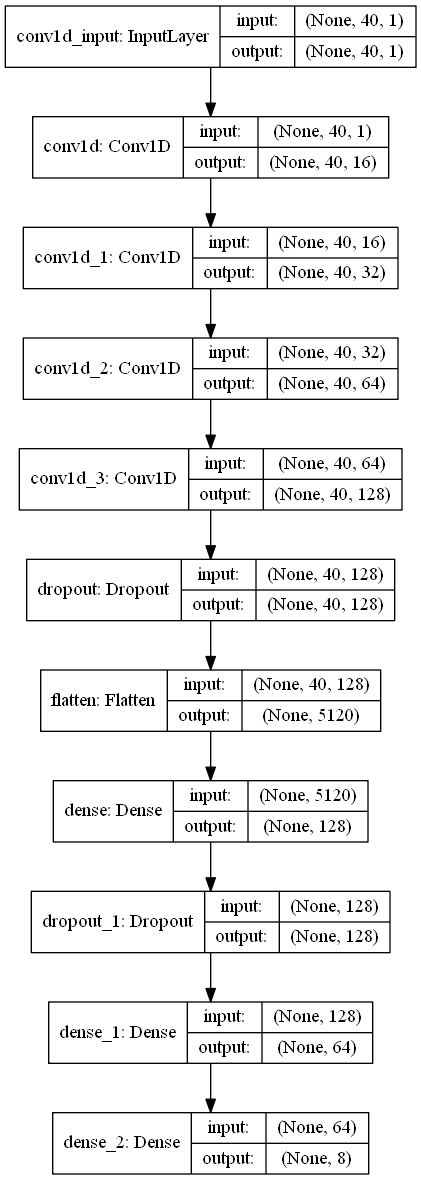

In [76]:
from keras.utils import plot_model

# Save an image of the model's architecture to a file
plot_model(CNN_model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

In [77]:
# Compile the model with the desired loss function, optimizer, and metric to optimize
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [78]:
from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5', 
                               verbose=1, save_best_only=True)

#Model fit
cnn_results = CNN_model.fit(x_traincnn, y_train_lb,
              batch_size = 64,
              epochs = 25,
              verbose = 1,
              validation_data = (x_testcnn, y_test_lb))

Train on 1320 samples, validate on 330 samples
Epoch 1/25
1320/1320 [==============================] - 75s 57ms/step - loss: 1.9666 - acc: 0.1932 - val_loss: 1.7637 - val_acc: 0.3515
Epoch 2/25
1320/1320 [==============================] - 105s 79ms/step - loss: 1.5662 - acc: 0.4288 - val_loss: 1.5203 - val_acc: 0.4424
Epoch 3/25
1320/1320 [==============================] - 85s 64ms/step - loss: 1.2893 - acc: 0.4886 - val_loss: 1.3362 - val_acc: 0.5182
Epoch 4/25
1320/1320 [==============================] - 94s 71ms/step - loss: 1.1034 - acc: 0.5879 - val_loss: 1.2304 - val_acc: 0.5455
Epoch 5/25
1320/1320 [==============================] - 95s 72ms/step - loss: 0.9321 - acc: 0.6523 - val_loss: 1.0891 - val_acc: 0.6273
Epoch 6/25
1320/1320 [==============================] - 81s 61ms/step - loss: 0.7882 - acc: 0.7015 - val_loss: 1.0779 - val_acc: 0.6061
Epoch 7/25
1320/1320 [==============================] - 82s 62ms/step - loss: 0.6814 - acc: 0.7470 - val_loss: 0.9930 - val_acc: 0.6424


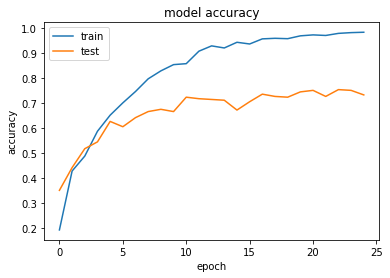

In [79]:
#Plot model accuracy over ephocs
plt.plot(cnn_results.history['acc'])
plt.plot(cnn_results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
# Calculate pre-training accuracy 
score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy) 

330/330 [==============================] - 0s 345us/step
Pre-training accuracy: 73.3333%


In [81]:
# Evaluating the model on the training and testing set
score = CNN_model.evaluate(x_traincnn, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.996969696969697
Testing Accuracy:  0.7333333340558139


# Add Confusion Matrix

In [82]:
#Get predictions from model
y_test_predictions = CNN_model.predict_classes(x_testcnn)
y_test_predictions

array([7, 5, 5, 1, 7, 6, 1, 3, 0, 2, 6, 1, 6, 1, 5, 6, 5, 0, 4, 5, 6, 0,
       5, 0, 2, 4, 1, 6, 1, 0, 0, 6, 2, 0, 4, 4, 0, 5, 3, 0, 0, 6, 7, 0,
       0, 6, 5, 1, 7, 6, 0, 0, 5, 3, 1, 5, 0, 3, 7, 6, 0, 3, 1, 1, 1, 1,
       0, 2, 0, 3, 0, 1, 1, 6, 5, 5, 6, 4, 6, 6, 3, 7, 0, 0, 6, 1, 4, 3,
       5, 0, 1, 4, 1, 7, 6, 5, 0, 4, 7, 2, 0, 2, 6, 4, 7, 6, 6, 2, 7, 4,
       4, 5, 4, 7, 5, 3, 4, 4, 5, 5, 6, 2, 1, 3, 4, 1, 2, 1, 4, 2, 1, 6,
       6, 5, 5, 5, 0, 7, 0, 3, 4, 0, 6, 1, 0, 6, 0, 4, 6, 5, 4, 4, 2, 1,
       2, 1, 0, 1, 4, 5, 6, 3, 4, 1, 1, 2, 3, 4, 6, 2, 2, 6, 1, 1, 0, 7,
       5, 3, 0, 0, 6, 2, 3, 7, 7, 6, 7, 1, 6, 1, 4, 4, 1, 5, 1, 6, 6, 1,
       5, 3, 3, 3, 4, 5, 6, 2, 5, 4, 3, 2, 0, 7, 7, 2, 6, 3, 7, 3, 2, 7,
       7, 1, 5, 6, 1, 3, 1, 1, 5, 1, 2, 2, 0, 4, 2, 3, 4, 0, 5, 5, 5, 0,
       5, 5, 2, 4, 2, 0, 6, 4, 4, 3, 3, 2, 4, 0, 3, 6, 6, 3, 2, 4, 6, 7,
       3, 4, 5, 4, 0, 0, 1, 0, 5, 0, 4, 7, 7, 6, 6, 0, 5, 1, 3, 4, 6, 3,
       3, 3, 5, 1, 4, 3, 0, 3, 2, 6, 3, 7, 2, 0, 6,

In [83]:
y_test

161       disgust
1023      neutral
1505      neutral
559          calm
804       neutral
          ...    
823         happy
1359          sad
575          fear
1250    surprised
534          calm
Name: emotion, Length: 330, dtype: object

In [84]:
#Get labels for emotions
y_labels_encoded

{0: 'angry',
 1: 'calm',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprised'}

In [85]:
# Change predictions to emotions in order to compare
y_test_predictions_labels =[]

#Go through each prediction and append to new list
for e in range(len(y_test_predictions)):
    y_test_predictions_labels.append(y_labels_encoded[y_test_predictions[e]])
    
#Build array of predictions
y_test_predictions_labels = np.array(y_test_predictions_labels)
y_test_predictions_labels

array(['surprised', 'neutral', 'neutral', 'calm', 'surprised', 'sad',
       'calm', 'fear', 'angry', 'disgust', 'sad', 'calm', 'sad', 'calm',
       'neutral', 'sad', 'neutral', 'angry', 'happy', 'neutral', 'sad',
       'angry', 'neutral', 'angry', 'disgust', 'happy', 'calm', 'sad',
       'calm', 'angry', 'angry', 'sad', 'disgust', 'angry', 'happy',
       'happy', 'angry', 'neutral', 'fear', 'angry', 'angry', 'sad',
       'surprised', 'angry', 'angry', 'sad', 'neutral', 'calm',
       'surprised', 'sad', 'angry', 'angry', 'neutral', 'fear', 'calm',
       'neutral', 'angry', 'fear', 'surprised', 'sad', 'angry', 'fear',
       'calm', 'calm', 'calm', 'calm', 'angry', 'disgust', 'angry',
       'fear', 'angry', 'calm', 'calm', 'sad', 'neutral', 'neutral',
       'sad', 'happy', 'sad', 'sad', 'fear', 'surprised', 'angry',
       'angry', 'sad', 'calm', 'happy', 'fear', 'neutral', 'angry',
       'calm', 'happy', 'calm', 'surprised', 'sad', 'neutral', 'angry',
       'happy', 'surpris

In [86]:
from sklearn.metrics import confusion_matrix

#Build confusion matrix and see results
confusion_matrix = confusion_matrix(y_test, y_test_predictions_labels)
confusion_matrix

array([[32,  0,  3,  1,  2,  0,  0,  1],
       [ 0, 39,  0,  0,  2,  0,  0,  0],
       [ 3,  0, 19,  3,  1,  0,  2,  4],
       [ 4,  3,  2, 31,  1,  0,  4,  4],
       [ 3,  2,  0,  2, 35,  0,  5,  3],
       [ 2,  3,  2,  0,  0, 40,  5,  1],
       [ 0,  1,  5,  2,  0,  1, 34,  2],
       [ 5,  0,  1,  2,  1,  0,  0, 12]], dtype=int64)

In [87]:
#See confusion matrix shape
confusion_matrix.shape

(8, 8)

In [88]:
#Turn al correct answers into 0 to visualize errors better
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        if i == j:
            confusion_matrix[i,j] = 0

# See results
confusion_matrix

array([[0, 0, 3, 1, 2, 0, 0, 1],
       [0, 0, 0, 0, 2, 0, 0, 0],
       [3, 0, 0, 3, 1, 0, 2, 4],
       [4, 3, 2, 0, 1, 0, 4, 4],
       [3, 2, 0, 2, 0, 0, 5, 3],
       [2, 3, 2, 0, 0, 0, 5, 1],
       [0, 1, 5, 2, 0, 1, 0, 2],
       [5, 0, 1, 2, 1, 0, 0, 0]], dtype=int64)

In [89]:
#Add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, columns=list(y_labels_encoded.values()), index=list(y_labels_encoded.values()))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix

The rows represents the true values or observations
The columns respresent the model's predictions


,angry,calm,disgust,fear,happy,neutral,sad,surprised
angry,0,0,3,1,2,0,0,1
calm,0,0,0,0,2,0,0,0
disgust,3,0,0,3,1,0,2,4
fear,4,3,2,0,1,0,4,4
happy,3,2,0,2,0,0,5,3
neutral,2,3,2,0,0,0,5,1
sad,0,1,5,2,0,1,0,2
surprised,5,0,1,2,1,0,0,0


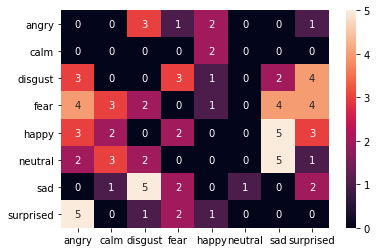

In [90]:
#Plot confusion matrix with results
ax = sns.heatmap(confusion_matrix, annot=True)

# Save CNN Model

In [91]:
from keras.models import model_from_json
# serialize model to json
json_model = CNN_model.to_json()
#save the model architecture to JSON file
with open('capstone_project_emotion_detection_final_version.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
CNN_model.save_weights('capstone_project_emotion_detection_final_version.h5')
#Model loss and accuracy
print("Saved model to disk")

Saved model to disk


In [92]:
# load json and create model
json_file = open('capstone_project_emotion_detection_final_version.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("capstone_project_emotion_detection_final_version.h5")
print("Loaded model from disk")

Loaded model from disk


In [93]:
from keras.initializers import glorot_uniform
#Reading the model from JSON file
with open('capstone_project_emotion_detection_final_version.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture 
model_load = keras.models.model_from_json(json_savedModel)
model_load.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 16)            96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 32)            2592      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 64)            10304     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 40, 128)           41088     
_________________________________________________________________
dropout (Dropout)            (None, 40, 128)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 128)              